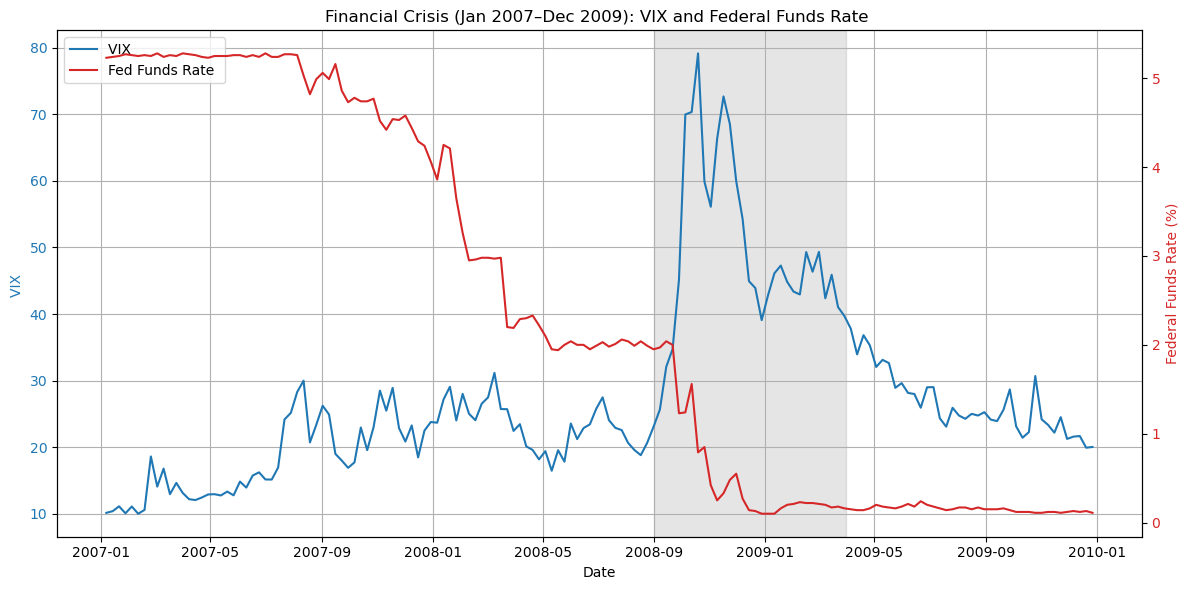

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# Settings
# -----------------------
file_path = "/Users/babo/Downloads/Data Science Project.csv"
date_col = "Date"

start_date = "2007-01-01"
end_date   = "2009-12-31"

vix_col  = "CBOE Volatility Index (VIX)"
rate_col = "Federal Funds Effective Rate (DFF)"

# -----------------------
# Load 
# -----------------------
df = pd.read_csv(file_path, sep=";", engine="python")

# Parse dates and sort
df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
df = df.sort_values(date_col).reset_index(drop=True)

# -----------------------
# Clean numeric columns
# (handles things like thousands separators and comma decimals)
# -----------------------
def clean_numeric(x):
    if isinstance(x, str):
        x = (x.replace("$", "")
               .replace("%", "")
               .replace(" ", "")
               .replace(".", "")   # remove thousands sep
               .replace(",", ".")) # convert decimal comma to dot
    return x

for col in [vix_col, rate_col]:
    df[col] = df[col].apply(clean_numeric)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# -----------------------
# Filter event window
# -----------------------
mask = (df[date_col] >= start_date) & (df[date_col] <= end_date)
df_win = df.loc[mask, [date_col, vix_col, rate_col]].dropna()

# -----------------------
# Plot: dual y-axis
# -----------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis: VIX 
ax1.plot(df_win[date_col], df_win[vix_col], color="tab:blue", label="VIX ")
ax1.set_xlabel("Date")
ax1.set_ylabel("VIX ", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right axis: Fed Funds Rate 
ax2 = ax1.twinx()
ax2.plot(df_win[date_col], df_win[rate_col], color="tab:red", label="Fed Funds Rate ")
ax2.set_ylabel("Federal Funds Rate (%)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Highlight core crisis phase
ax1.axvspan(pd.to_datetime("2008-09-01"), pd.to_datetime("2009-03-31"),
            color="grey", alpha=0.2)

plt.title("Financial Crisis (Jan 2007–Dec 2009): VIX and Federal Funds Rate ")

# Combined legend (one legend for both axes)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

ax1.grid(True)
plt.tight_layout()
plt.show()


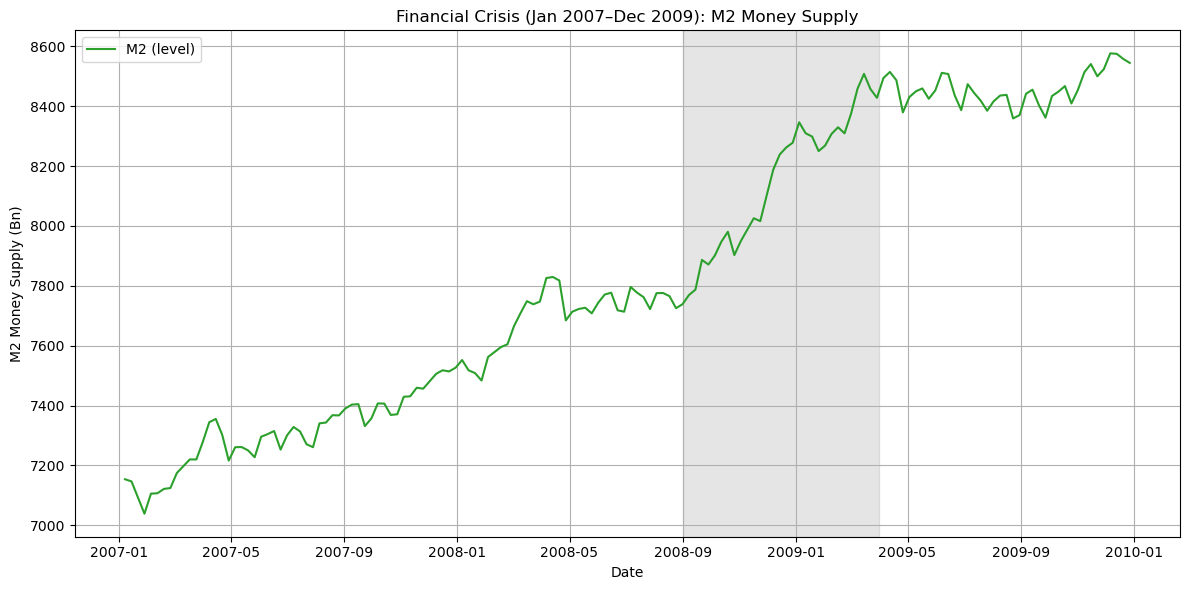

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# Settings
# -----------------------
file_path = "/Users/babo/Downloads/Data Science Project.csv"
date_col = "Date"

start_date = "2007-01-01"
end_date   = "2009-12-31"

# Same shaded crisis window used in the VIX + rate plot
shade_start = "2008-09-01"
shade_end   = "2009-03-31"

m2_col = "M2 Money Supply (Bn)"

# -----------------------
# Load levels dataset (semicolon-separated)
# -----------------------
df = pd.read_csv(file_path, sep=";", engine="python")

# Parse dates and sort
df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
df = df.sort_values(date_col).reset_index(drop=True)

# Clean numeric formatting (handles thousand separators + decimal commas)
def clean_numeric(x):
    if isinstance(x, str):
        x = (x.replace("$", "")
               .replace(" ", "")
               .replace(".", "")   # remove thousands separators
               .replace(",", ".")) # convert decimal comma to dot
    return x

df[m2_col] = df[m2_col].apply(clean_numeric)
df[m2_col] = pd.to_numeric(df[m2_col], errors="coerce")

# -----------------------
# Filter event window
# -----------------------
mask = (df[date_col] >= start_date) & (df[date_col] <= end_date)
df_win = df.loc[mask, [date_col, m2_col]].dropna()

# -----------------------
# Plot M2 levels + shaded crisis window
# -----------------------
plt.figure(figsize=(12, 6))
plt.plot(df_win[date_col], df_win[m2_col], color="tab:green", label="M2 (level)")

# Shaded region for core crisis phase
plt.axvspan(pd.to_datetime(shade_start), pd.to_datetime(shade_end), color="grey", alpha=0.2)

plt.title("Financial Crisis (Jan 2007–Dec 2009): M2 Money Supply")
plt.xlabel("Date")
plt.ylabel("M2 Money Supply (Bn)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


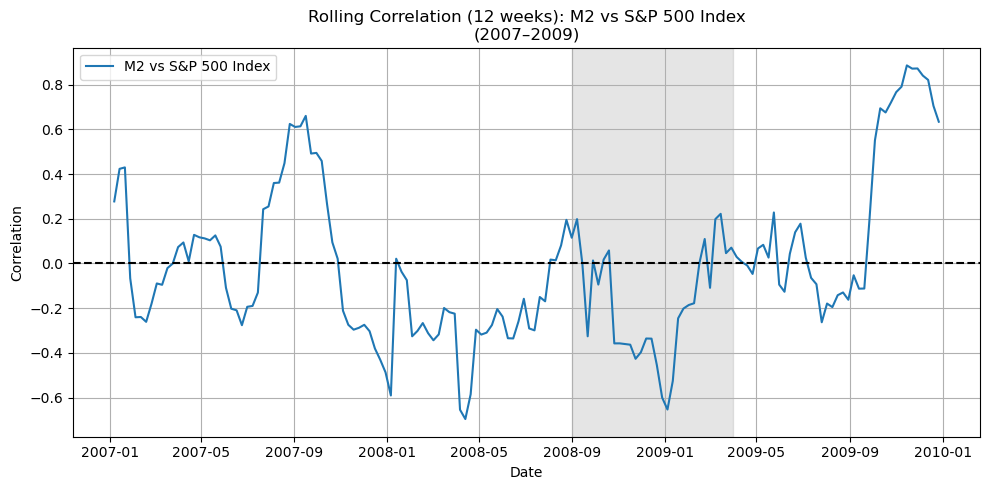

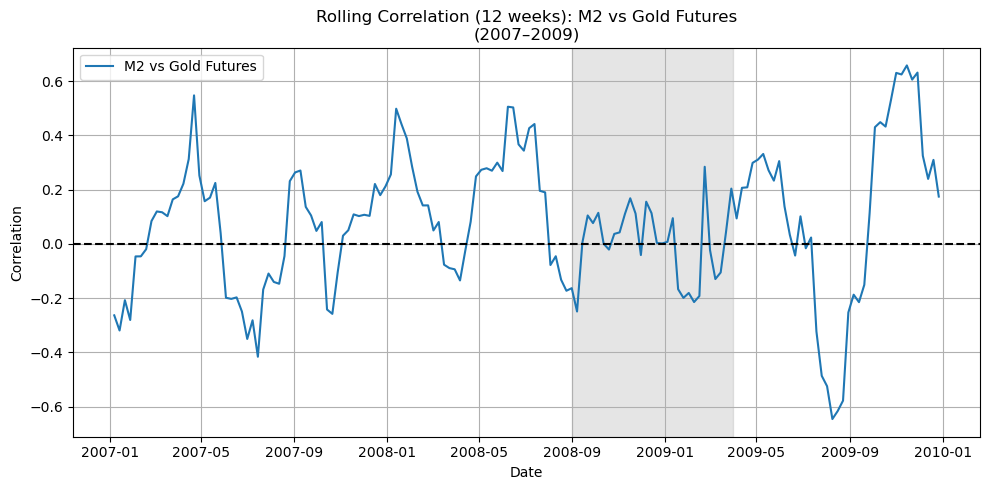

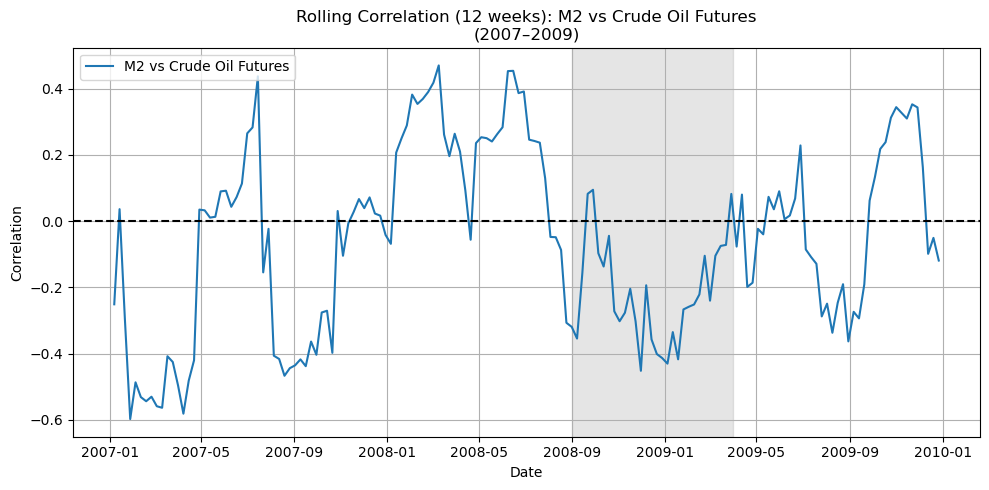

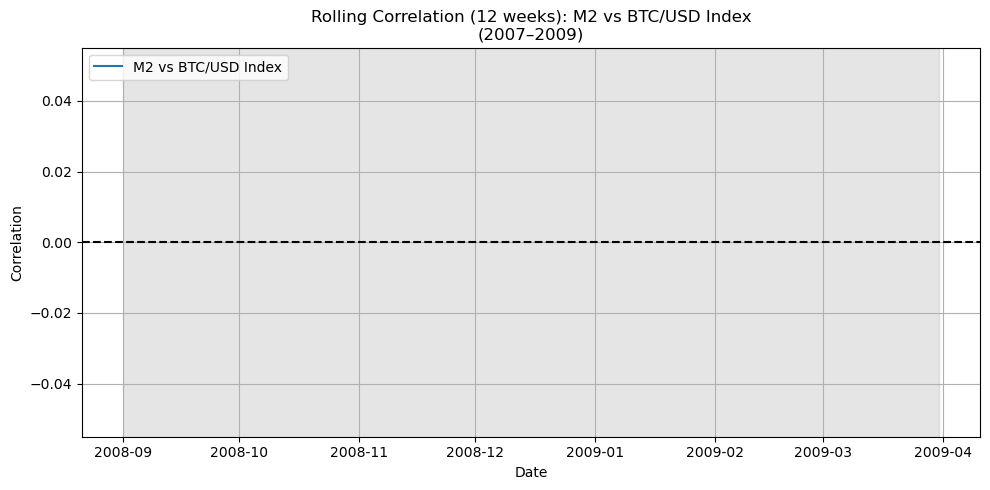

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------
# Config
# -----------------------
FILE = Path("/Users/babo/Downloads/Group-project-Data_Percent_Changes.csv")
WINDOW_WEEKS = 12
date_col = "Date"

# Financial Crisis window 
start_date = "2007-01-01"
end_date   = "2009-12-31"

# Shaded core crisis window (same as VIX + rates + M2 levels plots)
shade_start = "2008-09-01"
shade_end   = "2009-03-31"

# Assets to analyze
assets = [
    "S&P 500 Index",
    "Gold Futures",
    "Crude Oil Futures",
    "BTC/USD Index"
]

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(FILE)

# Parse dates and sort
df[date_col] = pd.to_datetime(df[date_col], format="%Y-%m-%d", errors="coerce")
df = df.sort_values(date_col).reset_index(drop=True)

# Convert all other columns to numeric 
for c in df.columns:
    if c != date_col:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Identify M2 column
m2_candidates = [c for c in df.columns if "m2" in c.lower()]
if not m2_candidates:
    raise ValueError("Could not find the M2 column.")
m2_col = m2_candidates[0]

# Keep only assets that exist in the dataset
assets = [c for c in assets if c in df.columns]

# -----------------------
# Compute rolling correlations 
# -----------------------
df_roll = df[[date_col]].copy()
for asset in assets:
    df_roll[asset] = df[m2_col].rolling(WINDOW_WEEKS).corr(df[asset])

# -----------------------
# Filter to the Financial Crisis display window
# -----------------------
mask = (df_roll[date_col] >= start_date) & (df_roll[date_col] <= end_date)
df_roll_win = df_roll.loc[mask].copy()

# -----------------------
# Plot each asset separately with shaded crisis window
# -----------------------
for asset in assets:
    plt.figure(figsize=(10, 5))
    plt.plot(df_roll_win[date_col], df_roll_win[asset], label=f"M2 vs {asset}")
    plt.axhline(0, linestyle="--", color="black")

    # shaded core crisis window
    plt.axvspan(pd.to_datetime(shade_start), pd.to_datetime(shade_end), color="grey", alpha=0.2)

    plt.title(f"Rolling Correlation ({WINDOW_WEEKS} weeks): M2 vs {asset}\n(2007–2009)")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()